In [1]:
#Exploring removal of transversal cross-relaxation pathways to obtain a Kite-type relaxation matrix
import sys
sys.path.append('./utils/')
import numpy as np
import scipy.io as spio
from scipy.linalg import expm
from matplotlib import pyplot as plt
import sys 
import openfermion as of
import pandas as pd

from analytical_fit import  KiteRelMatrixMany, Get_K2RatesAndOps, Get_K1RatesAndOps, Get_K0RatesAndOps, GammaRates,  get_chemical_shifts, Get_Det_And_Rates
from basis_utils import read_spinach_info, build_list_ISTs, NormalizeBasis, build_symbolic_list_ISTs

import copy

In [41]:
def Get_RatesAndOps(freqs,tc,coords,Nspins,gamma):
    """ 
    Returns: 1) a list of damping rates 2) the corresponding list of pairs of jump operators, where each pair defines a Linblad channel \mathcal{L}_{A,B} as defined in the notes
    Args:
    freqs: list of chemically shifted Zeeman frequencies of the spins
    tc: rotational correlatio0n time of the isotropic solvent
    coords: list that contains the cartesian coordinates of the spins
    Nspins: number of spins
    gamma; gyromagnetic ratio of the spins (it is assumed a homonuclear case)
    """
    
    ratesK2,OpsK2,Str_OpsK2=Get_K2RatesAndOps(freqs,tc,coords,Nspins,gamma)
    ratesK1,OpsK1,Str_OpsK1=Get_K1RatesAndOps(freqs,tc,coords,Nspins,gamma)
    ratesK0,OpsK0,Str_OpsK0=Get_K0RatesAndOps(freqs,tc,coords,Nspins,gamma)

    tot_rates=ratesK2+ratesK1+ratesK0
    tot_Ops=OpsK2+OpsK1+OpsK0
    tot_strs = Str_OpsK2+Str_OpsK1+Str_OpsK0
    return 0.25*np.array(tot_rates),tot_Ops, tot_strs

def is_diagonal(matrix):
    # Compare the matrix with its diagonal (converted back to a full matrix)
    return np.all(matrix == np.diag(np.diag(matrix)))

# Ratios of damping rates and detunings in rotating frame

In [68]:
#Testing list of parameters for DFG...

#offset = -46681
gammaF = 251814800
B0 = 9.3933
w0 = -gammaF*B0
#o1 = 2*np.pi*offset
#complete Zeeeman frequencies obtained from Spinach
w1 = -376417768.6316 
w2 = -376411775.1523 
freqs = np.array([w1,w2])
#coordinates
coord1 = np.array([-0.0551,-1.2087,-1.6523])*1e-10
coord2 = np.array([-0.8604 ,-2.3200 ,-0.0624])*1e-10
coords = np.array([coord1,coord2])
tc =  0.5255e-9 #correlation time
Nspins = 2 

#The chemical shifts in ppm, used as input in Spinach
zeeman_scalar_1 = -113.8796
zeeman_scalar_2 = -129.8002
zeeman_scalars = [zeeman_scalar_1,zeeman_scalar_2]

#w0*zeeman_scalars[i]/1e6
chem_shifts = get_chemical_shifts(gammaF,B0,zeeman_scalars)


list_jumps, list_damp_rates, list_dets=Get_Det_And_Rates(2*np.pi*freqs,tc,coords,Nspins,gammaF,chem_shifts)



In [71]:
# Create the DataFrame
df = pd.DataFrame({
    'Jump Ops': list_jumps,
    'Damp Rates (rad/s)': list_damp_rates,
    'Detunings (rad/s)': list_dets
})

# Display the DataFrame
print(df)

            Jump Ops  Damp Rates (rad/s)  Detunings (rad/s)
0   [S0+S1+, S0-S1-]            0.114401       5.820766e-11
1   [S0-S1-, S0+S1+]            0.114401       5.820766e-11
2   [S0zS1+, S0zS1-]            0.322737       0.000000e+00
3   [S0zS1-, S0zS1+]            0.322737       0.000000e+00
4   [S0+S1z, S0zS1-]            0.322737       3.765814e+04
5   [S0zS1-, S0+S1z]            0.322737       3.765814e+04
6   [S0+S1z, S0-S1z]            0.322731       0.000000e+00
7   [S0-S1z, S0+S1z]            0.322731       0.000000e+00
8   [S0zS1+, S0-S1z]            0.322731       3.765814e+04
9   [S0-S1z, S0zS1+]            0.322731       3.765814e+04
10  [S0zS1z, S0zS1z]            2.190013       0.000000e+00
11  [S0+S1-, S0zS1z]            0.547503       3.765814e+04
12  [S0zS1z, S0+S1-]            0.547503       3.765814e+04
13  [S0zS1z, S0-S1+]            0.547503       3.765814e+04
14  [S0-S1+, S0zS1z]            0.547503       3.765814e+04
15  [S0+S1-, S0-S1+]            0.136876

# Alanine damping rates and detunings

In [2]:
tc = 0.05e-9 # in seconds
gammaH = 2.6752e8
B0 =14.1
Nspins = 4

w1 = -600344544.5579
w2 = -600343524.536
w3 = -600343524.536
w4 = -600343524.536

freqs = np.array([w1,w2,w3,w4])

coords = np.array([
    [ 0.6861,0.2705,1.5010],
    [1.3077, 1.1298, -1.3993],
    [0.7905, 2.2125, -0.0860],
    [ 2.3693, 1.3798, 0.0233]
])

coords = coords*1e-10

#isotropic chemical shifts in ppm taken from the chemical shift tensors introduced in Spinach
zeeman_scalar_1 = 3.4938
zeeman_scalar_2 = 1.7947
zeeman_scalar_3 = 1.7947
zeeman_scalar_4 = 1.7947

zeeman_scalars = [zeeman_scalar_1,zeeman_scalar_2,zeeman_scalar_3,zeeman_scalar_4]

chem_shifts = get_chemical_shifts(gammaH,B0,zeeman_scalars)


list_jumps, list_damp_rates, list_dets=Get_Det_And_Rates(2*np.pi*freqs,tc,coords,Nspins,gammaH,chem_shifts)


In [3]:
# Create the DataFrame
df = pd.DataFrame({
    'Jump Ops': list_jumps,
    'Damp Rates (rad/s)': list_damp_rates,
    'Detunings (rad/s)': list_dets
})

# Display the DataFrame
print(df)

             Jump Ops  Damp Rates (rad/s)  Detunings (rad/s)
0    [S0+S1+, S0-S1-]            0.008624           0.000000
1    [S0-S1-, S0+S1+]            0.008624           0.000000
2    [S0zS1+, S0zS1-]            0.009513           0.000000
3    [S0zS1-, S0zS1+]            0.009513           0.000000
4    [S0+S1z, S0zS1-]            0.009513        6409.059571
..                ...                 ...                ...
679  [S2-S3+, S2zS3z]            0.174166           0.000000
680  [S2+S3-, S2-S3+]            0.043542           0.000000
681  [S2-S3+, S2+S3-]            0.043542           0.000000
682  [S2-S3+, S2-S3+]            0.043542           0.000000
683  [S2-S3+, S2-S3+]            0.043542           0.000000

[684 rows x 3 columns]


# The DFG case

In [42]:
loadMat = spio.loadmat('./data/DFG_kite.mat',squeeze_me=True)

R_refKite= loadMat['p']['R'].item()
H_refKite = loadMat['p']['H'].item()

In [43]:
###Analytically generated ZZ-terms,
text="""1      (0,0)   (0,0)   
  2      (0,0)   (1,1)   
  3      (0,0)   (1,0)   
  4      (0,0)   (1,-1)  
  5      (1,1)   (0,0)   
  6      (1,1)   (1,1)   
  7      (1,1)   (1,0)   
  8      (1,1)   (1,-1)  
  9      (1,0)   (0,0)   
  10     (1,0)   (1,1)   
  11     (1,0)   (1,0)   
  12     (1,0)   (1,-1)  
  13     (1,-1)  (0,0)   
  14     (1,-1)  (1,1)   
  15     (1,-1)  (1,0)   
  16     (1,-1)  (1,-1)  
"""


gammaF = 251814800
coord1 = np.array([-0.0551,-1.2087,-1.6523])*1e-10
coord2 = np.array([-0.8604 ,-2.3200 ,-0.0624])*1e-10

coords = np.array([coord1,coord2])
w1 = -376417768.6316 
w2 = -376411775.1523 
freqs = np.array([w1,w2])

tc =  0.5255e-9
Nspins = 2 

data = read_spinach_info(text)

basis = build_list_ISTs(data)

Normbasis = NormalizeBasis(basis,n_qubits=2,checkOrth=True)

In [5]:
R_kite_dev = KiteRelMatrixMany(2*np.pi*freqs,tc,coords,Nspins,gammaF,Normbasis)
R_kite_approx = ApproxKiteMany(2*np.pi*freqs,tc,coords,Nspins,gammaF,Normbasis)

Finished computing the K2 type contributions
Finished computing the K1 type contributions
Finished computing the K0 type contributions
Finished computing the K1 type contributions
Finished computing the K0 type contributions


In [6]:
np.linalg.norm(R_refKite-R_kite_dev)

0.0017873835640859778

In [7]:
np.linalg.norm(R_refKite-R_kite_approx)

0.6459184908148382

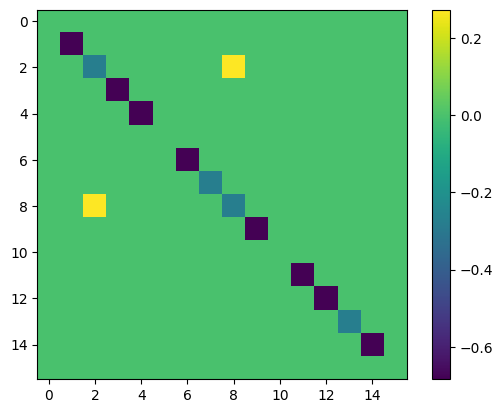

In [9]:
plt.imshow(np.real(R_kite_approx), cmap='viridis', interpolation='nearest')
# Add a color bar to sh-1j*ow the scale
plt.colorbar()

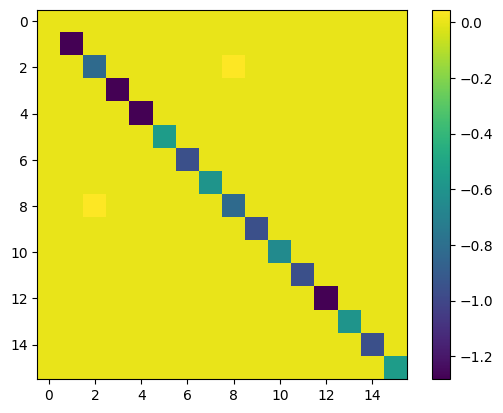

In [6]:
plt.imshow(np.real(R_kite_dev), cmap='viridis', interpolation='nearest')
# Add a color bar to sh-1j*ow the scale
plt.colorbar()

In [8]:
np.linalg.norm(R_refKite-R_kite_dev)

0.0017873835640859778

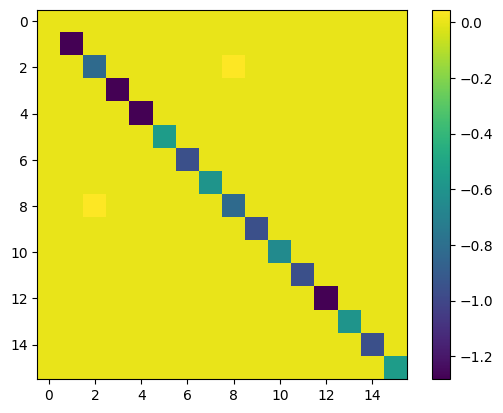

In [9]:
plt.imshow(np.real(R_refKite), cmap='viridis', interpolation='nearest')
# Add a color bar to sh-1j*ow the scale
plt.colorbar()

# Checking the 4 spin case

In [8]:
import pickle

In [9]:
loadMat = spio.loadmat('./data/ALA_NOESY_withGradients_kite.mat',squeeze_me=True)

R_refALAKite= loadMat['p']['R'].item()
R_refALAKite=R_refALAKite.toarray()
H_refALAKite = loadMat['p']['H'].item()

In [10]:
f = open('./data/ALA_Analytical_Kite.pk','rb')
data = pickle.load(f)

ALA_Analytical_Kite = data['KiteMat']

In [11]:
#Collecting off-diagonal indexes....

Ref_Kite_offidxs = []
AN_Kite_offdixs = []

for i in range(256):
    for j in range(i+1,256):
        if np.abs(R_refALAKite[i,j])!=0:
            Ref_Kite_offidxs.append([i,j])
        if np.abs(ALA_Analytical_Kite[i,j])!=0:
            AN_Kite_offdixs.append([i,j])

#collect all the indexes that are not in the reference...

Extra_offidxs_ALA = []
for idx in AN_Kite_offdixs:
    if idx not in Ref_Kite_offidxs:
        Extra_offidxs_ALA.append(idx)



In [18]:
sum_off = 0.0

list_off_values = []
for idx in Extra_offidxs_ALA:
    sum_off+=np.abs(ALA_Analytical_Kite[idx[0],idx[1]])
    list_off_values.append(ALA_Analytical_Kite[idx[0],idx[1]])


In [36]:
diff=0.0
for i in range(256):
    diff+=np.abs(R_refALAKite[i,i]-ALA_Analytical_Kite[i,i])


In [38]:
diff/256

0.06425369883525303

In [39]:
np.diag(R_refALAKite)

array([ 0.        +0.j, -1.74919009+0.j, -1.68958886+0.j, -1.74919009+0.j,
       -1.78472988+0.j, -2.52290813+0.j, -2.42520965+0.j, -2.29450392+0.j,
       -1.7239392 +0.j, -2.42399897+0.j, -2.32450054+0.j, -2.42399897+0.j,
       -1.78472988+0.j, -2.29450392+0.j, -2.42520965+0.j, -2.52290813+0.j,
       -1.69609165+0.j, -2.43466071+0.j, -2.35168549+0.j, -2.2378731 +0.j,
       -2.44382745+0.j, -2.39809851+0.j, -2.10809152+0.j, -1.65709032+0.j,
       -2.33725378+0.j, -2.09468537+0.j, -1.9038369 +0.j, -1.76197844+0.j,
       -2.19515167+0.j, -1.62953743+0.j, -1.74391787+0.j, -1.65333307+0.j,
       -1.63832069+0.j, -2.35350966+0.j, -2.25454433+0.j, -2.35350966+0.j,
       -2.34028862+0.j, -2.1091586 +0.j, -1.90741754+0.j, -1.75140322+0.j,
       -2.23824941+0.j, -1.90433717+0.j, -1.76544553+0.j, -1.90433717+0.j,
       -2.34028862+0.j, -1.75140322+0.j, -1.90741754+0.j, -2.1091586 +0.j,
       -1.69609165+0.j, -2.2378731 +0.j, -2.35168549+0.j, -2.43466071+0.j,
       -2.19515167+0.j, -

In [35]:
np.linalg.norm(np.diag(ALA_Analytical_Kite)-np.diag(R_refALAKite))

1.6486728558822372

In [33]:
np.sum(np.abs(list_off_values))/len(list_off_values)

0.03513270827257491

In [34]:
np.sum(np.abs(np.diag(ALA_Analytical_Kite)))/256

2.030772637636818

In [31]:
Symb_ALA_basis[73], Symb_ALA_basis[97]

(' S+0   Sz2 S+3', ' S+0 Sz1   S+3')

In [24]:
ALA_Analytical_Kite[73,97]

(-0.38220176938405204+0j)

In [21]:
np.argmax(np.abs(list_off_values))

91

In [22]:
list_off_values[91]

(-0.38220176938405204+0j)

In [71]:
Symb_ALA_basis[8], Symb_ALA_basis[128]

('     Sz2  ', ' Sz0      ')

In [74]:
Symb_ALA_basis[6], Symb_ALA_basis[36]

('     S+2 Sz3', '   Sz1 S+2  ')

In [80]:
from openfermion import QubitOperator
from basis_utils import S_plus,S_minus,Sz,InnProd


def AN_Lib(rho,A,B):
    return A*rho*B-0.5*(A*B*rho+rho*A*B)

A = S_plus(1) * S_plus(3)
B = S_minus(1)*S_minus(3)

rho = Sz(1)*S_plus(2)


#AN_Lib(rho,A,B)

InnProd(Sz(3)*S_plus(2),AN_Lib(rho,B,A),n_qubits=4)

(-1+0j)

In [48]:
InnProd(Op1,Op2,n_qubits=None)

[[6, 36],
 [6, 132],
 [9, 33],
 [9, 129],
 [11, 35],
 [11, 131],
 [14, 44],
 [14, 140],
 [18, 24],
 [18, 144],
 [21, 23],
 [21, 29],
 [21, 31],
 [21, 53],
 [21, 55],
 [21, 61],
 [21, 63],
 [22, 148],
 [23, 29],
 [23, 31],
 [23, 53],
 [23, 55],
 [23, 61],
 [23, 63],
 [24, 144],
 [25, 145],
 [26, 146],
 [26, 152],
 [27, 147],
 [29, 31],
 [29, 53],
 [29, 55],
 [29, 61],
 [29, 63],
 [30, 156],
 [31, 53],
 [31, 55],
 [31, 61],
 [31, 63],
 [33, 129],
 [35, 131],
 [36, 132],
 [37, 133],
 [38, 134],
 [38, 164],
 [39, 135],
 [41, 137],
 [41, 161],
 [43, 139],
 [43, 163],
 [44, 140],
 [45, 141],
 [46, 142],
 [46, 172],
 [47, 143],
 [50, 56],
 [50, 176],
 [53, 55],
 [53, 61],
 [53, 63],
 [53, 181],
 [54, 180],
 [55, 61],
 [55, 63],
 [55, 183],
 [56, 176],
 [57, 177],
 [58, 178],
 [58, 184],
 [59, 179],
 [61, 63],
 [61, 189],
 [62, 188],
 [63, 191],
 [66, 72],
 [66, 96],
 [69, 71],
 [69, 77],
 [69, 79],
 [69, 197],
 [69, 199],
 [69, 205],
 [69, 207],
 [70, 100],
 [71, 77],
 [71, 79],
 [71, 197],
 

In [44]:
len(AN_Kite_offdixs)

444

In [46]:
[2,8] in Ref_Kite_offidxs

True

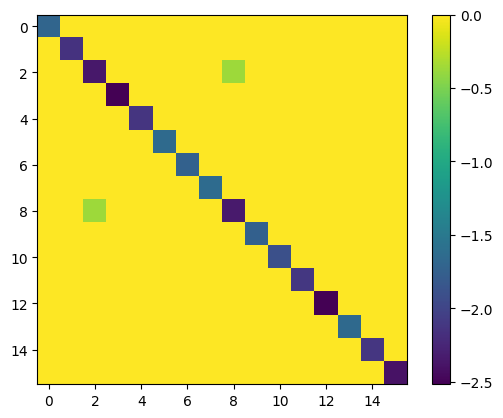

In [40]:
init =48 
fin = 64

plt.imshow(np.real(ALA_Analytical_Kite[init:fin,init:fin]), cmap='viridis', interpolation='nearest')
# Add a color bar to sh-1j*ow the scale
plt.colorbar()

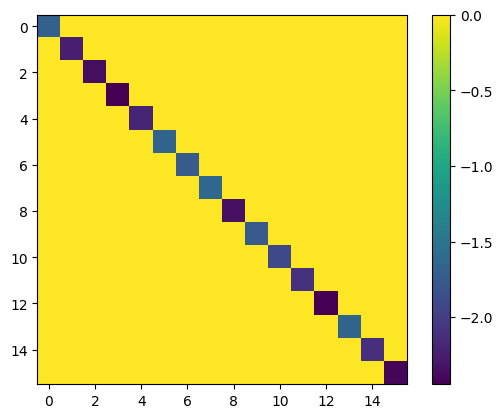

In [41]:
plt.imshow(np.real(R_refALAKite[init:fin,init:fin]), cmap='viridis', interpolation='nearest')
# Add a color bar to show the scale
plt.colorbar()

In [26]:
np.linalg.norm(ALA_Analytical_Kite)

33.30238499387605

In [ ]:
#Load the analytically generated Kite matrix:
loadMat = spio.loadmat('./data/ALA_Analytical_Kite.pk')

In [19]:
np.linalg.norm(R_refALAKite)

33.21719025949559

In [25]:
text4="""1      (0,0)   (0,0)   (0,0)   (0,0)   
  2      (0,0)   (0,0)   (0,0)   (1,1)   
  3      (0,0)   (0,0)   (0,0)   (1,0)   
  4      (0,0)   (0,0)   (0,0)   (1,-1)  
  5      (0,0)   (0,0)   (1,1)   (0,0)   
  6      (0,0)   (0,0)   (1,1)   (1,1)   
  7      (0,0)   (0,0)   (1,1)   (1,0)   
  8      (0,0)   (0,0)   (1,1)   (1,-1)  
  9      (0,0)   (0,0)   (1,0)   (0,0)   
  10     (0,0)   (0,0)   (1,0)   (1,1)   
  11     (0,0)   (0,0)   (1,0)   (1,0)   
  12     (0,0)   (0,0)   (1,0)   (1,-1)  
  13     (0,0)   (0,0)   (1,-1)  (0,0)   
  14     (0,0)   (0,0)   (1,-1)  (1,1)   
  15     (0,0)   (0,0)   (1,-1)  (1,0)   
  16     (0,0)   (0,0)   (1,-1)  (1,-1)  
  17     (0,0)   (1,1)   (0,0)   (0,0)   
  18     (0,0)   (1,1)   (0,0)   (1,1)   
  19     (0,0)   (1,1)   (0,0)   (1,0)   
  20     (0,0)   (1,1)   (0,0)   (1,-1)  
  21     (0,0)   (1,1)   (1,1)   (0,0)   
  22     (0,0)   (1,1)   (1,1)   (1,1)   
  23     (0,0)   (1,1)   (1,1)   (1,0)   
  24     (0,0)   (1,1)   (1,1)   (1,-1)  
  25     (0,0)   (1,1)   (1,0)   (0,0)   
  26     (0,0)   (1,1)   (1,0)   (1,1)   
  27     (0,0)   (1,1)   (1,0)   (1,0)   
  28     (0,0)   (1,1)   (1,0)   (1,-1)  
  29     (0,0)   (1,1)   (1,-1)  (0,0)   
  30     (0,0)   (1,1)   (1,-1)  (1,1)   
  31     (0,0)   (1,1)   (1,-1)  (1,0)   
  32     (0,0)   (1,1)   (1,-1)  (1,-1)  
  33     (0,0)   (1,0)   (0,0)   (0,0)   
  34     (0,0)   (1,0)   (0,0)   (1,1)   
  35     (0,0)   (1,0)   (0,0)   (1,0)   
  36     (0,0)   (1,0)   (0,0)   (1,-1)  
  37     (0,0)   (1,0)   (1,1)   (0,0)   
  38     (0,0)   (1,0)   (1,1)   (1,1)   
  39     (0,0)   (1,0)   (1,1)   (1,0)   
  40     (0,0)   (1,0)   (1,1)   (1,-1)  
  41     (0,0)   (1,0)   (1,0)   (0,0)   
  42     (0,0)   (1,0)   (1,0)   (1,1)   
  43     (0,0)   (1,0)   (1,0)   (1,0)   
  44     (0,0)   (1,0)   (1,0)   (1,-1)  
  45     (0,0)   (1,0)   (1,-1)  (0,0)   
  46     (0,0)   (1,0)   (1,-1)  (1,1)   
  47     (0,0)   (1,0)   (1,-1)  (1,0)   
  48     (0,0)   (1,0)   (1,-1)  (1,-1)  
  49     (0,0)   (1,-1)  (0,0)   (0,0)   
  50     (0,0)   (1,-1)  (0,0)   (1,1)   
  51     (0,0)   (1,-1)  (0,0)   (1,0)   
  52     (0,0)   (1,-1)  (0,0)   (1,-1)  
  53     (0,0)   (1,-1)  (1,1)   (0,0)   
  54     (0,0)   (1,-1)  (1,1)   (1,1)   
  55     (0,0)   (1,-1)  (1,1)   (1,0)   
  56     (0,0)   (1,-1)  (1,1)   (1,-1)  
  57     (0,0)   (1,-1)  (1,0)   (0,0)   
  58     (0,0)   (1,-1)  (1,0)   (1,1)   
  59     (0,0)   (1,-1)  (1,0)   (1,0)   
  60     (0,0)   (1,-1)  (1,0)   (1,-1)  
  61     (0,0)   (1,-1)  (1,-1)  (0,0)   
  62     (0,0)   (1,-1)  (1,-1)  (1,1)   
  63     (0,0)   (1,-1)  (1,-1)  (1,0)   
  64     (0,0)   (1,-1)  (1,-1)  (1,-1)  
  65     (1,1)   (0,0)   (0,0)   (0,0)   
  66     (1,1)   (0,0)   (0,0)   (1,1)   
  67     (1,1)   (0,0)   (0,0)   (1,0)   
  68     (1,1)   (0,0)   (0,0)   (1,-1)  
  69     (1,1)   (0,0)   (1,1)   (0,0)   
  70     (1,1)   (0,0)   (1,1)   (1,1)   
  71     (1,1)   (0,0)   (1,1)   (1,0)   
  72     (1,1)   (0,0)   (1,1)   (1,-1)  
  73     (1,1)   (0,0)   (1,0)   (0,0)   
  74     (1,1)   (0,0)   (1,0)   (1,1)   
  75     (1,1)   (0,0)   (1,0)   (1,0)   
  76     (1,1)   (0,0)   (1,0)   (1,-1)  
  77     (1,1)   (0,0)   (1,-1)  (0,0)   
  78     (1,1)   (0,0)   (1,-1)  (1,1)   
  79     (1,1)   (0,0)   (1,-1)  (1,0)   
  80     (1,1)   (0,0)   (1,-1)  (1,-1)  
  81     (1,1)   (1,1)   (0,0)   (0,0)   
  82     (1,1)   (1,1)   (0,0)   (1,1)   
  83     (1,1)   (1,1)   (0,0)   (1,0)   
  84     (1,1)   (1,1)   (0,0)   (1,-1)  
  85     (1,1)   (1,1)   (1,1)   (0,0)   
  86     (1,1)   (1,1)   (1,1)   (1,1)   
  87     (1,1)   (1,1)   (1,1)   (1,0)   
  88     (1,1)   (1,1)   (1,1)   (1,-1)  
  89     (1,1)   (1,1)   (1,0)   (0,0)   
  90     (1,1)   (1,1)   (1,0)   (1,1)   
  91     (1,1)   (1,1)   (1,0)   (1,0)   
  92     (1,1)   (1,1)   (1,0)   (1,-1)  
  93     (1,1)   (1,1)   (1,-1)  (0,0)   
  94     (1,1)   (1,1)   (1,-1)  (1,1)   
  95     (1,1)   (1,1)   (1,-1)  (1,0)   
  96     (1,1)   (1,1)   (1,-1)  (1,-1)  
  97     (1,1)   (1,0)   (0,0)   (0,0)   
  98     (1,1)   (1,0)   (0,0)   (1,1)   
  99     (1,1)   (1,0)   (0,0)   (1,0)   
  100    (1,1)   (1,0)   (0,0)   (1,-1)  
  101    (1,1)   (1,0)   (1,1)   (0,0)   
  102    (1,1)   (1,0)   (1,1)   (1,1)   
  103    (1,1)   (1,0)   (1,1)   (1,0)   
  104    (1,1)   (1,0)   (1,1)   (1,-1)  
  105    (1,1)   (1,0)   (1,0)   (0,0)   
  106    (1,1)   (1,0)   (1,0)   (1,1)   
  107    (1,1)   (1,0)   (1,0)   (1,0)   
  108    (1,1)   (1,0)   (1,0)   (1,-1)  
  109    (1,1)   (1,0)   (1,-1)  (0,0)   
  110    (1,1)   (1,0)   (1,-1)  (1,1)   
  111    (1,1)   (1,0)   (1,-1)  (1,0)   
  112    (1,1)   (1,0)   (1,-1)  (1,-1)  
  113    (1,1)   (1,-1)  (0,0)   (0,0)   
  114    (1,1)   (1,-1)  (0,0)   (1,1)   
  115    (1,1)   (1,-1)  (0,0)   (1,0)   
  116    (1,1)   (1,-1)  (0,0)   (1,-1)  
  117    (1,1)   (1,-1)  (1,1)   (0,0)   
  118    (1,1)   (1,-1)  (1,1)   (1,1)   
  119    (1,1)   (1,-1)  (1,1)   (1,0)   
  120    (1,1)   (1,-1)  (1,1)   (1,-1)  
  121    (1,1)   (1,-1)  (1,0)   (0,0)   
  122    (1,1)   (1,-1)  (1,0)   (1,1)   
  123    (1,1)   (1,-1)  (1,0)   (1,0)   
  124    (1,1)   (1,-1)  (1,0)   (1,-1)  
  125    (1,1)   (1,-1)  (1,-1)  (0,0)   
  126    (1,1)   (1,-1)  (1,-1)  (1,1)   
  127    (1,1)   (1,-1)  (1,-1)  (1,0)   
  128    (1,1)   (1,-1)  (1,-1)  (1,-1)  
  129    (1,0)   (0,0)   (0,0)   (0,0)   
  130    (1,0)   (0,0)   (0,0)   (1,1)   
  131    (1,0)   (0,0)   (0,0)   (1,0)   
  132    (1,0)   (0,0)   (0,0)   (1,-1)  
  133    (1,0)   (0,0)   (1,1)   (0,0)   
  134    (1,0)   (0,0)   (1,1)   (1,1)   
  135    (1,0)   (0,0)   (1,1)   (1,0)   
  136    (1,0)   (0,0)   (1,1)   (1,-1)  
  137    (1,0)   (0,0)   (1,0)   (0,0)   
  138    (1,0)   (0,0)   (1,0)   (1,1)   
  139    (1,0)   (0,0)   (1,0)   (1,0)   
  140    (1,0)   (0,0)   (1,0)   (1,-1)  
  141    (1,0)   (0,0)   (1,-1)  (0,0)   
  142    (1,0)   (0,0)   (1,-1)  (1,1)   
  143    (1,0)   (0,0)   (1,-1)  (1,0)   
  144    (1,0)   (0,0)   (1,-1)  (1,-1)  
  145    (1,0)   (1,1)   (0,0)   (0,0)   
  146    (1,0)   (1,1)   (0,0)   (1,1)   
  147    (1,0)   (1,1)   (0,0)   (1,0)   
  148    (1,0)   (1,1)   (0,0)   (1,-1)  
  149    (1,0)   (1,1)   (1,1)   (0,0)   
  150    (1,0)   (1,1)   (1,1)   (1,1)   
  151    (1,0)   (1,1)   (1,1)   (1,0)   
  152    (1,0)   (1,1)   (1,1)   (1,-1)  
  153    (1,0)   (1,1)   (1,0)   (0,0)   
  154    (1,0)   (1,1)   (1,0)   (1,1)   
  155    (1,0)   (1,1)   (1,0)   (1,0)   
  156    (1,0)   (1,1)   (1,0)   (1,-1)  
  157    (1,0)   (1,1)   (1,-1)  (0,0)   
  158    (1,0)   (1,1)   (1,-1)  (1,1)   
  159    (1,0)   (1,1)   (1,-1)  (1,0)   
  160    (1,0)   (1,1)   (1,-1)  (1,-1)  
  161    (1,0)   (1,0)   (0,0)   (0,0)   
  162    (1,0)   (1,0)   (0,0)   (1,1)   
  163    (1,0)   (1,0)   (0,0)   (1,0)   
  164    (1,0)   (1,0)   (0,0)   (1,-1)  
  165    (1,0)   (1,0)   (1,1)   (0,0)   
  166    (1,0)   (1,0)   (1,1)   (1,1)   
  167    (1,0)   (1,0)   (1,1)   (1,0)   
  168    (1,0)   (1,0)   (1,1)   (1,-1)  
  169    (1,0)   (1,0)   (1,0)   (0,0)   
  170    (1,0)   (1,0)   (1,0)   (1,1)   
  171    (1,0)   (1,0)   (1,0)   (1,0)   
  172    (1,0)   (1,0)   (1,0)   (1,-1)  
  173    (1,0)   (1,0)   (1,-1)  (0,0)   
  174    (1,0)   (1,0)   (1,-1)  (1,1)   
  175    (1,0)   (1,0)   (1,-1)  (1,0)   
  176    (1,0)   (1,0)   (1,-1)  (1,-1)  
  177    (1,0)   (1,-1)  (0,0)   (0,0)   
  178    (1,0)   (1,-1)  (0,0)   (1,1)   
  179    (1,0)   (1,-1)  (0,0)   (1,0)   
  180    (1,0)   (1,-1)  (0,0)   (1,-1)  
  181    (1,0)   (1,-1)  (1,1)   (0,0)   
  182    (1,0)   (1,-1)  (1,1)   (1,1)   
  183    (1,0)   (1,-1)  (1,1)   (1,0)   
  184    (1,0)   (1,-1)  (1,1)   (1,-1)  
  185    (1,0)   (1,-1)  (1,0)   (0,0)   
  186    (1,0)   (1,-1)  (1,0)   (1,1)   
  187    (1,0)   (1,-1)  (1,0)   (1,0)   
  188    (1,0)   (1,-1)  (1,0)   (1,-1)  
  189    (1,0)   (1,-1)  (1,-1)  (0,0)   
  190    (1,0)   (1,-1)  (1,-1)  (1,1)   
  191    (1,0)   (1,-1)  (1,-1)  (1,0)   
  192    (1,0)   (1,-1)  (1,-1)  (1,-1)  
  193    (1,-1)  (0,0)   (0,0)   (0,0)   
  194    (1,-1)  (0,0)   (0,0)   (1,1)   
  195    (1,-1)  (0,0)   (0,0)   (1,0)   
  196    (1,-1)  (0,0)   (0,0)   (1,-1)  
  197    (1,-1)  (0,0)   (1,1)   (0,0)   
  198    (1,-1)  (0,0)   (1,1)   (1,1)   
  199    (1,-1)  (0,0)   (1,1)   (1,0)   
  200    (1,-1)  (0,0)   (1,1)   (1,-1)  
  201    (1,-1)  (0,0)   (1,0)   (0,0)   
  202    (1,-1)  (0,0)   (1,0)   (1,1)   
  203    (1,-1)  (0,0)   (1,0)   (1,0)   
  204    (1,-1)  (0,0)   (1,0)   (1,-1)  
  205    (1,-1)  (0,0)   (1,-1)  (0,0)   
  206    (1,-1)  (0,0)   (1,-1)  (1,1)   
  207    (1,-1)  (0,0)   (1,-1)  (1,0)   
  208    (1,-1)  (0,0)   (1,-1)  (1,-1)  
  209    (1,-1)  (1,1)   (0,0)   (0,0)   
  210    (1,-1)  (1,1)   (0,0)   (1,1)   
  211    (1,-1)  (1,1)   (0,0)   (1,0)   
  212    (1,-1)  (1,1)   (0,0)   (1,-1)  
  213    (1,-1)  (1,1)   (1,1)   (0,0)   
  214    (1,-1)  (1,1)   (1,1)   (1,1)   
  215    (1,-1)  (1,1)   (1,1)   (1,0)   
  216    (1,-1)  (1,1)   (1,1)   (1,-1)  
  217    (1,-1)  (1,1)   (1,0)   (0,0)   
  218    (1,-1)  (1,1)   (1,0)   (1,1)   
  219    (1,-1)  (1,1)   (1,0)   (1,0)   
  220    (1,-1)  (1,1)   (1,0)   (1,-1)  
  221    (1,-1)  (1,1)   (1,-1)  (0,0)   
  222    (1,-1)  (1,1)   (1,-1)  (1,1)   
  223    (1,-1)  (1,1)   (1,-1)  (1,0)   
  224    (1,-1)  (1,1)   (1,-1)  (1,-1)  
  225    (1,-1)  (1,0)   (0,0)   (0,0)   
  226    (1,-1)  (1,0)   (0,0)   (1,1)   
  227    (1,-1)  (1,0)   (0,0)   (1,0)   
  228    (1,-1)  (1,0)   (0,0)   (1,-1)  
  229    (1,-1)  (1,0)   (1,1)   (0,0)   
  230    (1,-1)  (1,0)   (1,1)   (1,1)   
  231    (1,-1)  (1,0)   (1,1)   (1,0)   
  232    (1,-1)  (1,0)   (1,1)   (1,-1)  
  233    (1,-1)  (1,0)   (1,0)   (0,0)   
  234    (1,-1)  (1,0)   (1,0)   (1,1)   
  235    (1,-1)  (1,0)   (1,0)   (1,0)   
  236    (1,-1)  (1,0)   (1,0)   (1,-1)  
  237    (1,-1)  (1,0)   (1,-1)  (0,0)   
  238    (1,-1)  (1,0)   (1,-1)  (1,1)   
  239    (1,-1)  (1,0)   (1,-1)  (1,0)   
  240    (1,-1)  (1,0)   (1,-1)  (1,-1)  
  241    (1,-1)  (1,-1)  (0,0)   (0,0)   
  242    (1,-1)  (1,-1)  (0,0)   (1,1)   
  243    (1,-1)  (1,-1)  (0,0)   (1,0)   
  244    (1,-1)  (1,-1)  (0,0)   (1,-1)  
  245    (1,-1)  (1,-1)  (1,1)   (0,0)   
  246    (1,-1)  (1,-1)  (1,1)   (1,1)   
  247    (1,-1)  (1,-1)  (1,1)   (1,0)   
  248    (1,-1)  (1,-1)  (1,1)   (1,-1)  
  249    (1,-1)  (1,-1)  (1,0)   (0,0)   
  250    (1,-1)  (1,-1)  (1,0)   (1,1)   
  251    (1,-1)  (1,-1)  (1,0)   (1,0)   
  252    (1,-1)  (1,-1)  (1,0)   (1,-1)  
  253    (1,-1)  (1,-1)  (1,-1)  (0,0)   
  254    (1,-1)  (1,-1)  (1,-1)  (1,1)   
  255    (1,-1)  (1,-1)  (1,-1)  (1,0)   
  256    (1,-1)  (1,-1)  (1,-1)  (1,-1)"""


In [26]:
data_ala = read_spinach_info(text4)

basis_ala = build_list_ISTs(data_ala)
prefacts,Symb_ALA_basis = build_symbolic_list_ISTs(data_ala)

#Normbasis = NormalizeBasis(basis,n_qubits=4,checkOrth=True) I have verified the orthonormalization of the basis
Normbasis_ala = NormalizeBasis(basis_ala,n_qubits=4,checkOrth=False)

In [13]:
###Testing a sub-matrix...

Sub_norm_basis = np.copy(Normbasis_ala[0:16])


In [28]:
tc = 0.05e-9 # in seconds
gammaH = 2.6752e8

w1 = -600344544.5579
w2 = -600343524.536
w3 = -600343524.536
w4 = -600343524.536


freqs = np.array([w1,w2,w3,w4])

coords = np.array([
    [ 0.6861,0.2705,1.5010],
    [1.3077, 1.1298, -1.3993],
    [0.7905, 2.2125, -0.0860],
    [ 2.3693, 1.3798, 0.0233]
])

coords = coords*1e-10

Nspins = 4

#R_kiteALA_dev = Kite_relMat(2*np.pi*freqs,tc,coords,Nspins,gammaH,Sub_norm_basis)
#R_kite_dev = KiteRelMatrixMany(2*np.pi*freqs,tc,coords,Nspins,gammaH,Sub_norm_basis)
rates_ALA,JOps_ALA,Symb_JOps_ALA = Get_RatesAndOps(2*np.pi*freqs,tc,coords,Nspins,gammaH)

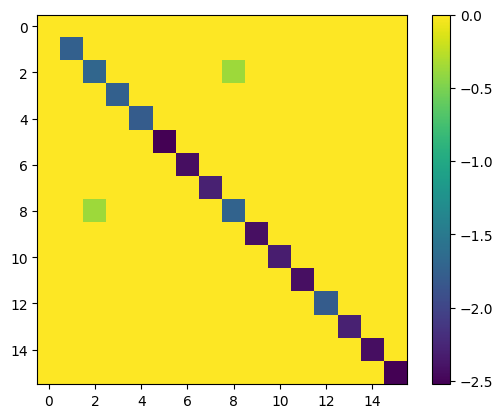

In [14]:
plt.imshow(np.real(R_refALAKite[0:16,0:16]), cmap='viridis', interpolation='nearest')
# Add a color bar to show the scale
plt.colorbar()

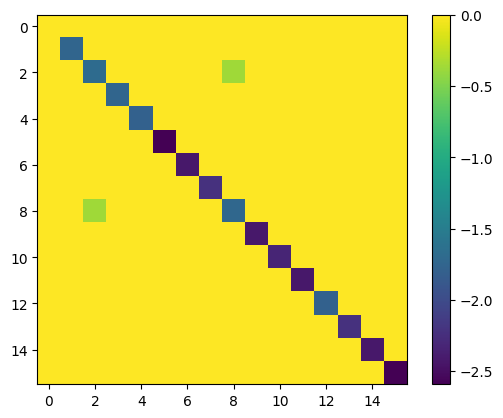

In [16]:
plt.imshow(np.real(R_kite_dev), cmap='viridis', interpolation='nearest')

# Add a color bar to show the scale
plt.colorbar()


In [17]:
np.linalg.norm(R_kite_dev-R_refALAKite[0:16,0:16]) # a good match nbetween the analytically generated Kite matrix and the reference SPinach kite matrix

0.1422004244994652